### Apparel인지 Footware인지 구별하는 인공지능 모델을 설계해 보자

##### 필요한 패키지들을 import한다

In [16]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn # Neural Network 모델 모음
from torch.autograd import Variable #미분값 자동계산 해 주는 함수
import torch.nn.functional as F # ReLU함수 등을 forward함수에서 쓰고 싶을 때 사용. 꼭 그렇게 사용하지 않고 __init__에서 nn.ReLU로도 가능

from torch.utils.data import DataLoader
import PIL # 이미지 열어주는 용도

import torchvision
import torchvision.transforms as transforms # 이미지를 텐서로 변환할 때 사용




import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# plt.imshow(...) 사용시 커널이 자꾸 죽는다면 이 2줄을 추가

### CUDA가 사용 가능한지 확인

In [17]:
torch.cuda.is_available()

True

### CUDA GPU 사용 가능하다면 사용하도록 설정

In [18]:
if(torch.cuda.is_available()):
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

### 이미지를 torch로 업로드하고 plt로 출력해보기

In [19]:
# PIL 패키지로 이미지를 연다.
img = PIL.Image.open("../images/Footwear/Men/1637.jpg")

# img객체를 tensor자료형으로 변환 (ToTensor객체 이용)
totensor = transforms.ToTensor()
img_t = totensor(img)

print(img_t.shape)

img_t = img_t.permute(1,2,0)
# tensor.permute()함수는 차원을 맞교환 하는 함수이다.
# 예를들어 1,2,0을 입력한다면 그것은 기존의 0번째, 1번째, 2번째 axis를 1번째, 2번째, 0번째 순서로 바꾼다는 뜻이다.

print(img_t.shape)
print(img_t[800,200,0]) # 값들이 정규화로 인해 전부 0~1사이로 변환되어 있음을 확인

torch.Size([3, 2400, 1800])
torch.Size([2400, 1800, 3])
tensor(0.8392)


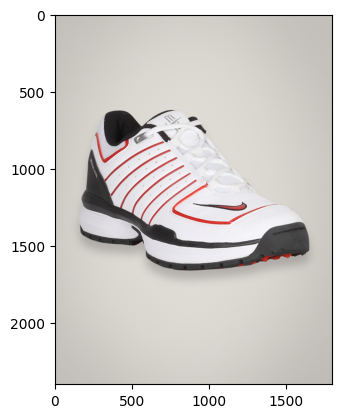

In [20]:
plt.imshow(img_t)
# imshow를 위해서는 axis가 row, column, channel 순으로 와야한다.
plt.show()

### 본격적으로 이미지세트를 불러와 보겠다. 이때를 위해 미리 디렉터리 구조를 osos.py와 osos2.py로 정리해 놓은 것이다

In [21]:
trans = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
# 이미지를 불러올 떄 불러온 이미지 변환을 위한 명령어들을 리스트 형태로 순차적으로 저장해 주는 객체이다
# Resize는 전체적인 이미지를 유지해 주면서 화질만 줄여준다고 생각하면 된다

totalset = torchvision.datasets.ImageFolder(root = "../img_CATEGORY", transform = trans)
# jpg등 이미지를 담은 폴더의 '상위폴더'를 가져와야 한다.
# 그러니까 ../a/label_n/img.jpg 라고 한다면 a폴더를 가져와야 한다.
# 왜냐하면 ImageFolder객체는 최상위 디렉터리 안에 있는 폴더별로 label을 지정하기 때문이다.

### 불러온 훈련세트 정보들을 파악한다

['Apparel', 'Footwear']
2906
(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]), 0)
torch.Size([3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


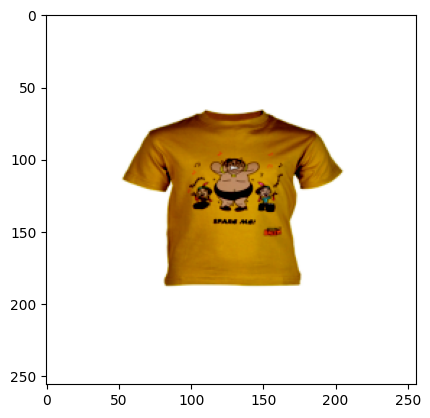

In [22]:
print(totalset.classes) # 클래스의 이름은 이미지를 담는 폴더의 이름을 따라간다. 여기서 라벨이 정해짐

print(len(totalset))
print(totalset.__getitem__(18)) # 0인덱스는 image 텐서정보, 1인덱스는 image 라벨정보
print(totalset.__getitem__(18)[0].shape)
print(totalset.__getitem__(18)[1]) # 라벨정보는 클래스 1개에 하나씩 부여되어 있다.
plt.imshow(totalset.__getitem__(18)[0].permute(1,2,0))

### trainset, validset, testset으로 분리한다.

In [23]:
from torch.utils.data import random_split

totalsize = len(totalset)
trainsize = int(totalsize * 0.8)
validsize = int(totalsize * 0.1)
testsize = totalsize - trainsize - validsize

trainset, validset, testset = random_split(totalset, [trainsize, validsize, testsize])

### DataLoader함수를 호출하여 한번에 batchsize만큼 학습하도록 한다
###### DataLoader는 for images, labels in trainloader 식으로 사용된다.

In [24]:
trainbatchsize = 16
validbatchsize = 4
testbatchsize = 4
trainloader = DataLoader(trainset, batch_size = trainbatchsize, shuffle = True)
validloader = DataLoader(validset, batch_size = validbatchsize, shuffle = True)
testloader = DataLoader(testset, batch_size = testbatchsize, shuffle = True)

In [25]:
dataiter = iter(trainloader) # iter메서드는 매개변수에 들어간 객체의 __iter__함수를 실행시켜 준다.
images, labels = next(dataiter) # next메서드는 매개변수에 들어간 객체의 __next__함수를 실행시켜 준다.
print(images.shape)
print(labels)

torch.Size([16, 3, 256, 256])
tensor([0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0])


### 이제 모델을 설계하자
###### __init__함수에는 멤버변수를 layer객체로 만들고 forward함수에는 layer들을 연결시켜준다.

#### 구조는 다음과 같다
##### 입력: 256, 256, 3
##### 256, 256, 8 (conv)
##### 128, 128, 8 (maxpool)
---------------------------------
##### 128, 128, 16 (conv)
##### 64, 64, 16 (maxpool)
---------------------------------
##### 64, 64, 32 (conv)
##### 32, 32, 32 (maxpool)
---------------------------------
##### 32, 32, 64 (conv)
##### 16, 16, 64 (maxpool)
---------------------------------
##### 16, 16, 128 (conv)
##### 8, 8, 128 (maxpool)
---------------------------------
##### 8, 8, 256 (conv)
##### 4, 4, 256 (maxpool)
---------------------------------
##### 4 * 4 * 256 // 2 (fully connected)
##### Dropout 0.25
---------------------------------
##### 4 * 4 * 256 // 4 (fully connected)
##### Dropout 0.25
---------------------------------
##### 4 * 4 * 256 // 8 (fully connected)
##### Dropout 0.25
---------------------------------
##### 4 * 4 * 256 // 16 (fully connected)
##### Dropout 0.25
##### 16 (fully connected)
##### 2 (fully connected)

In [26]:
class CategoryCNN(nn.Module):
    def __init__(self):
        super(CategoryCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features = 4*4*256, out_features = (4*4*256)//2)
        self.drop1 = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features = (4*4*256)//2, out_features = (4*4*256)//4)
        self.drop2 = nn.Dropout2d(0.25)
        self.fc3 = nn.Linear(in_features = (4*4*256)//4, out_features = (4*4*256)//8)
        self.drop3 = nn.Dropout2d(0.25)
        self.fc4 = nn.Linear(in_features = (4*4*256)//8, out_features = (4*4*256)//16)
        self.drop4 = nn.Dropout2d(0.25)
        self.fc5 = nn.Linear(in_features = (4*4*256)//16, out_features = 16)
        self.fc6 = nn.Linear(in_features = 16, out_features = 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = out.view(out.size(0), -1) # flatten작업
        out = self.fc1(out)
        out = self.drop1(out)
        out = self.fc2(out)
        out = self.drop2(out)
        out = self.fc3(out)
        out = self.drop3(out)
        out = self.fc4(out)
        out = self.drop4(out)
        out = self.fc5(out)
        out = self.fc6(out)
        return out

### 모델 객체 생성

In [27]:
CategoryModel = CategoryCNN()
CategoryModel.to(device)

CategoryCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNo

### 학습률, 오차함수, 옵티마이저를 정의하자

In [28]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CategoryModel.parameters(), lr = learning_rate)

### 모델을 실제로 학습시킨다

In [29]:
num_epochs = 6
batchcount = 0

for epoch in range(num_epochs):
    batchcount = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        if(len(images) != trainbatchsize):
            trainnow = Variable(images.view(-1, 3, 256, 256))
        else:
            trainnow = Variable(images.view(16, 3, 256, 256))
        labels = Variable(labels)

        outputs = CategoryModel(trainnow)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batchcount += 1
        print("%dth epoch and %dth trainloader" %(epoch + 1, batchcount))

1th epoch and 1th trainloader
1th epoch and 2th trainloader
1th epoch and 3th trainloader
1th epoch and 4th trainloader
1th epoch and 5th trainloader
1th epoch and 6th trainloader
1th epoch and 7th trainloader
1th epoch and 8th trainloader
1th epoch and 9th trainloader
1th epoch and 10th trainloader
1th epoch and 11th trainloader
1th epoch and 12th trainloader
1th epoch and 13th trainloader
1th epoch and 14th trainloader
1th epoch and 15th trainloader
1th epoch and 16th trainloader
1th epoch and 17th trainloader
1th epoch and 18th trainloader
1th epoch and 19th trainloader
1th epoch and 20th trainloader
1th epoch and 21th trainloader
1th epoch and 22th trainloader
1th epoch and 23th trainloader
1th epoch and 24th trainloader
1th epoch and 25th trainloader
1th epoch and 26th trainloader
1th epoch and 27th trainloader
1th epoch and 28th trainloader
1th epoch and 29th trainloader
1th epoch and 30th trainloader
1th epoch and 31th trainloader
1th epoch and 32th trainloader
1th epoch and 33t

In [30]:
correct = 0
total = 0
count = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = CategoryModel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        count += 1
        print("count: %d" %(count))

print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))

count: 1
count: 2
count: 3
count: 4
count: 5
count: 6
count: 7
count: 8
count: 9
count: 10
count: 11
count: 12
count: 13
count: 14
count: 15
count: 16
count: 17
count: 18
count: 19
count: 20
count: 21
count: 22
count: 23
count: 24
count: 25
count: 26
count: 27
count: 28
count: 29
count: 30
count: 31
count: 32
count: 33
count: 34
count: 35
count: 36
count: 37
count: 38
count: 39
count: 40
count: 41
count: 42
count: 43
count: 44
count: 45
count: 46
count: 47
count: 48
count: 49
count: 50
count: 51
count: 52
count: 53
count: 54
count: 55
count: 56
count: 57
count: 58
count: 59
count: 60
count: 61
count: 62
count: 63
count: 64
count: 65
count: 66
count: 67
count: 68
count: 69
count: 70
count: 71
count: 72
count: 73
Accuracy of the network on the 292 test images: 98 %
